source https://discourse.pymc.io/t/specifying-hierarchical-binomial-model-when-individuals-have-varying-numbers-of-trials/3889

https://people.duke.edu/~ccc14/sta-663/PyMC2.html

We have 5 coins from machine A and 1 coin from machine B, we want to assess if machine A and machine B have the same manufacturing parameters.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pymc as pm 
import pandas as pd
import arviz as az

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# 5 coins from machine A
coin_data_A = [
    [0]*25+[1]*30,
    [0]*40+[1]*50,
    [0]*10+[1]*40,
    [0]*60+[1]*40,
    [0]*50+[1]*30,
]
coin_data_A = [np.random.choice(tosses, size=len(tosses), replace=False) for tosses in coin_data_A]
n_coins_A = len(coin_data_A)
print('tosses for 5 coins')
print(coin_data_A)

# coin index of each toss
coin_data_A_index = [[i]*len(coin) for i, coin in enumerate(coin_data_A)]
print('coin index for the tosses')
print(coin_data_A_index)

# flatten the data
coin_data_A = np.hstack(coin_data_A)
coin_data_A_index = np.hstack(coin_data_A_index)

nvect_A, pvect_A = [], [] 
for i in np.unique(coin_data_A_index): 
    idx = coin_data_A_index == i 
    nvect_A.append(idx.sum()) 
    pvect_A.append(coin_data_A[idx].sum())
pvect_A, nvect_A

tosses for 5 coins
[array([1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1]), array([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1]), array([1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1]), array([0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0

In [14]:
# 1 coin from machine B
coin_data_B = [
    [0]*10+[1]*100
]
coin_data_B = [np.random.choice(tosses, size=len(tosses), replace=False) for tosses in coin_data_B]
n_coins_B = len(coin_data_B)
print('tosses for 1 coin')
print(coin_data_B)

# coin index of each toss
coin_data_B_index = [[i]*len(coin) for i, coin in enumerate(coin_data_B)]
print('coin index for the tosses')
print(coin_data_B_index)

# flatten the data
coin_data_B = np.hstack(coin_data_B)
coin_data_B_index = np.hstack(coin_data_B_index)

nvect_B, pvect_B = [], [] 
for i in np.unique(coin_data_B_index): 
    idx = coin_data_B_index == i 
    nvect_B.append(idx.sum()) 
    pvect_B.append(coin_data_B[idx].sum())
pvect_B, nvect_B

tosses for 1 coin
[array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])]
coin index for the tosses
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


([100], [110])

In [15]:
with pm.Model() as bag_of_coins_model:
    ### machine A
    ## hyperpriors
    alpha_A = pm.HalfNormal('alpha_A', 5.0) 
    beta_A = pm.HalfNormal('beta_A', 5.0) 
    
    ## prior p for each coin
    p_A = pm.Beta("p_A", alpha=alpha_A, beta=beta_A, shape=n_coins_A)

    ## coin tosses
    heads_A = pm.Binomial('heads_A', n=nvect_A, p=p_A, observed=pvect_A)
    
    ### machine B
    ## hyperpriors
    alpha_B = pm.HalfNormal('alpha_B', 5.0) 
    beta_B = pm.HalfNormal('beta_B', 5.0) 
    
    ## prior p for single coin
    p_B = pm.Beta("p_B", alpha=alpha_B, beta=beta_B, shape=n_coins_B)
    
    ## coin tosses
    heads_B = pm.Binomial('heads_B', n=nvect_B, p=p_B, observed=pvect_B)
    
    ## difference between the parameters of machine A and machine B
    delta_alpha = pm.Deterministic('delta_alpha', alpha_A-alpha_B)
    delta_beta = pm.Deterministic('delta_beta', beta_A-beta_B)

    trace = pm.sample(2000, tune=2000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_A, beta_A, p_A, alpha_B, beta_B, p_B]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 35 seconds.


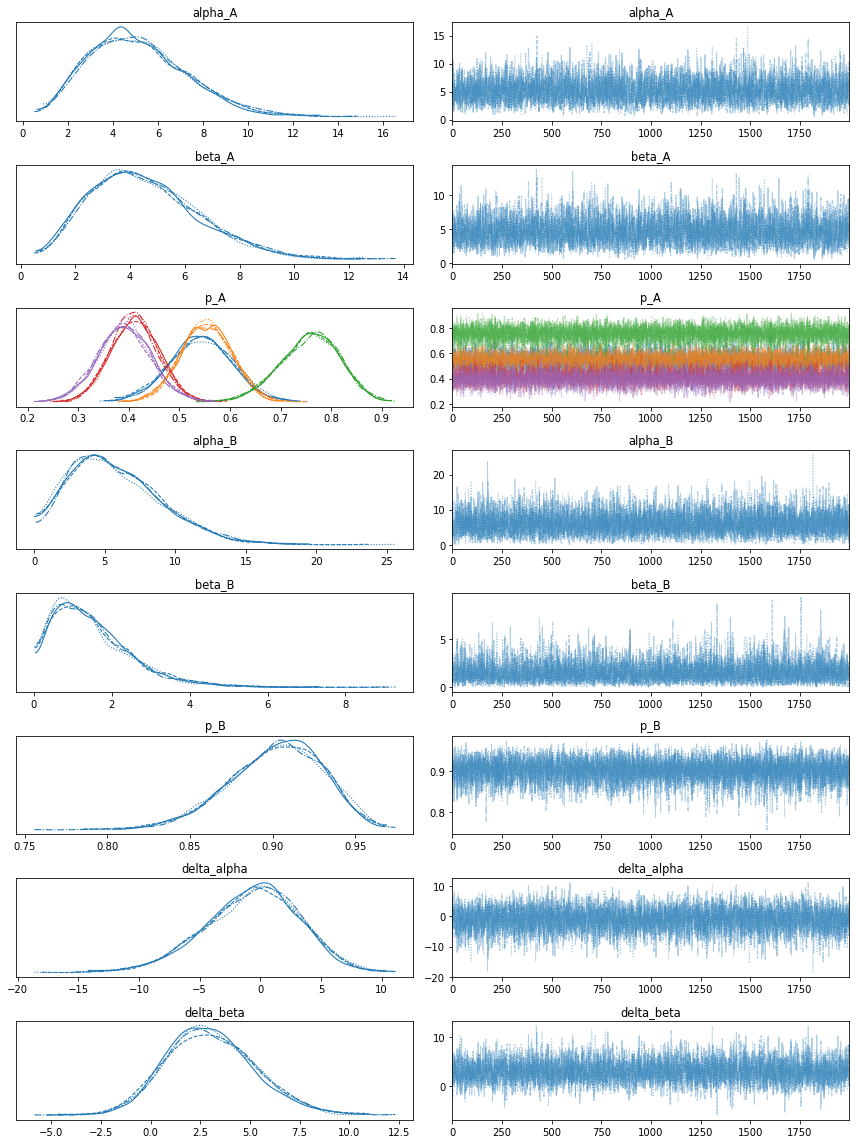

In [16]:
az.plot_trace(trace)
plt.tight_layout()
plt.draw()

delta_alpha and delta_beta is telling us how different the two factories are